# Introduction
- nb19 でヒントを得た情報を使う。
- どうやら、fcとdso(in conrib)は、`scalar coupling constant`と高い相関があるらしい。
- しかし、`scalar_soupling_contributions`内に記述されている分子は、`train`の分子のみしか情報がない。
- 手法:
    1. train データを用いて、test データの`fc`と`dso`を予測する。
    2. そのデータを新しい特徴量として、testデータに加える。
    3. `fc`は、`scalar_coupling_constant`と相関が高いので、いい特徴量になりえるはず！
- ref:
    > https://www.kaggle.com/artgor/using-meta-features-to-improve-model

# Import everything I nead :)

In [1]:
import time
import glob
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from fastprogress import progress_bar

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


# Preparation

In [2]:
nb = 20
isSmallSet = False
step = 1000

In [3]:
pd.set_option('display.max_columns', 100)

In [40]:
file_path = './input/champs-scalar-coupling/'
glob.glob(file_path + '*')

['./input/champs-scalar-coupling/sample_submission.csv',
 './input/champs-scalar-coupling/potential_energy.csv',
 './input/champs-scalar-coupling/train.csv',
 './input/champs-scalar-coupling/scalar_coupling_contributions.csv',
 './input/champs-scalar-coupling/structures.csv',
 './input/champs-scalar-coupling/test.csv',
 './input/champs-scalar-coupling/magnetic_shielding_tensors.csv',
 './input/champs-scalar-coupling/dipole_moments.csv',
 './input/champs-scalar-coupling/mulliken_charges.csv']

In [5]:
# train
path = file_path + 'train.csv'
if isSmallSet:
    train = pd.read_csv(path) [::step]
else:
    train = pd.read_csv(path)

In [6]:
# test
path = file_path + 'test.csv'
if isSmallSet:
    test = pd.read_csv(path)[::step]
else:
    test = pd.read_csv(path)

In [7]:
# structure
path = file_path + 'structures.csv'
structures = pd.read_csv(path)

In [8]:
# scalar coupling contributions
path = file_path + 'scalar_coupling_contributions.csv'
if isSmallSet:
    contrib = pd.read_csv(path)[::step]
else:
    contrib = pd.read_csv(path)

In [9]:
if isSmallSet:
    print('using SmallSet !!')
    print('-------------------')

print(f'There are {train.shape[0]} rows in train data.')
print(f'There are {test.shape[0]} rows in test data.')

print(f"There are {train['molecule_name'].nunique()} distinct molecules in train data.")
print(f"There are {test['molecule_name'].nunique()} distinct molecules in test data.")
print(f"There are {train['atom_index_0'].nunique()} unique atoms.")
print(f"There are {train['type'].nunique()} unique types.")

There are 4658147 rows in train data.
There are 2505542 rows in test data.
There are 85003 distinct molecules in train data.
There are 45772 distinct molecules in test data.
There are 29 unique atoms.
There are 8 unique types.


---
**metrics**

In [10]:
def kaggle_metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)

# Feature Engineering

**basic**

In [11]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

distances

In [12]:
train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
train['dist_x'] = (train['x_0'] - train['x_1']) ** 2
test['dist_x'] = (test['x_0'] - test['x_1']) ** 2
train['dist_y'] = (train['y_0'] - train['y_1']) ** 2
test['dist_y'] = (test['y_0'] - test['y_1']) ** 2
train['dist_z'] = (train['z_0'] - train['z_1']) ** 2
test['dist_z'] = (test['z_0'] - test['z_1']) ** 2

`type` の特徴量から、数字を抽出  
例) 2JHC ---> 2

In [13]:
train['type_0'] = train['type'].apply(lambda x: x[0])
test['type_0'] = test['type'].apply(lambda x: x[0])

---
続いて、**分子単位**の特徴量を抽出する。

In [14]:
def create_features(df):
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    
    df[f'molecule_atom_index_0_x_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['x_1'].transform('std')
    df[f'molecule_atom_index_0_y_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('mean')
    df[f'molecule_atom_index_0_y_1_mean_diff'] = df[f'molecule_atom_index_0_y_1_mean'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_mean_div'] = df[f'molecule_atom_index_0_y_1_mean'] / df['y_1']
    df[f'molecule_atom_index_0_y_1_max'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('max')
    df[f'molecule_atom_index_0_y_1_max_diff'] = df[f'molecule_atom_index_0_y_1_max'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('std')
    df[f'molecule_atom_index_0_z_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['z_1'].transform('std')
    df[f'molecule_atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('mean')
    df[f'molecule_atom_index_0_dist_mean_diff'] = df[f'molecule_atom_index_0_dist_mean'] - df['dist']
    df[f'molecule_atom_index_0_dist_mean_div'] = df[f'molecule_atom_index_0_dist_mean'] / df['dist']
    df[f'molecule_atom_index_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('max')
    df[f'molecule_atom_index_0_dist_max_diff'] = df[f'molecule_atom_index_0_dist_max'] - df['dist']
    df[f'molecule_atom_index_0_dist_max_div'] = df[f'molecule_atom_index_0_dist_max'] / df['dist']
    df[f'molecule_atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df[f'molecule_atom_index_0_dist_min_diff'] = df[f'molecule_atom_index_0_dist_min'] - df['dist']
    df[f'molecule_atom_index_0_dist_min_div'] = df[f'molecule_atom_index_0_dist_min'] / df['dist']
    df[f'molecule_atom_index_0_dist_std'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('std')
    df[f'molecule_atom_index_0_dist_std_diff'] = df[f'molecule_atom_index_0_dist_std'] - df['dist']
    df[f'molecule_atom_index_0_dist_std_div'] = df[f'molecule_atom_index_0_dist_std'] / df['dist']
    df[f'molecule_atom_index_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('mean')
    df[f'molecule_atom_index_1_dist_mean_diff'] = df[f'molecule_atom_index_1_dist_mean'] - df['dist']
    df[f'molecule_atom_index_1_dist_mean_div'] = df[f'molecule_atom_index_1_dist_mean'] / df['dist']
    df[f'molecule_atom_index_1_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('max')
    df[f'molecule_atom_index_1_dist_max_diff'] = df[f'molecule_atom_index_1_dist_max'] - df['dist']
    df[f'molecule_atom_index_1_dist_max_div'] = df[f'molecule_atom_index_1_dist_max'] / df['dist']
    df[f'molecule_atom_index_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('min')
    df[f'molecule_atom_index_1_dist_min_diff'] = df[f'molecule_atom_index_1_dist_min'] - df['dist']
    df[f'molecule_atom_index_1_dist_min_div'] = df[f'molecule_atom_index_1_dist_min'] / df['dist']
    df[f'molecule_atom_index_1_dist_std'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('std')
    df[f'molecule_atom_index_1_dist_std_diff'] = df[f'molecule_atom_index_1_dist_std'] - df['dist']
    df[f'molecule_atom_index_1_dist_std_div'] = df[f'molecule_atom_index_1_dist_std'] / df['dist']
    df[f'molecule_atom_1_dist_mean'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('mean')
    df[f'molecule_atom_1_dist_min'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('min')
    df[f'molecule_atom_1_dist_min_diff'] = df[f'molecule_atom_1_dist_min'] - df['dist']
    df[f'molecule_atom_1_dist_min_div'] = df[f'molecule_atom_1_dist_min'] / df['dist']
    df[f'molecule_atom_1_dist_std'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('std')
    df[f'molecule_atom_1_dist_std_diff'] = df[f'molecule_atom_1_dist_std'] - df['dist']
    df[f'molecule_type_0_dist_std'] = df.groupby(['molecule_name', 'type_0'])['dist'].transform('std')
    df[f'molecule_type_0_dist_std_diff'] = df[f'molecule_type_0_dist_std'] - df['dist']
    df[f'molecule_type_dist_mean'] = df.groupby(['molecule_name', 'type'])['dist'].transform('mean')
    df[f'molecule_type_dist_mean_diff'] = df[f'molecule_type_dist_mean'] - df['dist']
    df[f'molecule_type_dist_mean_div'] = df[f'molecule_type_dist_mean'] / df['dist']
    df[f'molecule_type_dist_max'] = df.groupby(['molecule_name', 'type'])['dist'].transform('max')
    df[f'molecule_type_dist_min'] = df.groupby(['molecule_name', 'type'])['dist'].transform('min')
    df[f'molecule_type_dist_std'] = df.groupby(['molecule_name', 'type'])['dist'].transform('std')
    df[f'molecule_type_dist_std_diff'] = df[f'molecule_type_dist_std'] - df['dist']

    return df

In [15]:
%%time
train = create_features(train)

CPU times: user 49.9 s, sys: 42.6 s, total: 1min 32s
Wall time: 1min 32s


In [16]:
%%time
test = create_features(test)

CPU times: user 22.2 s, sys: 23 s, total: 45.2 s
Wall time: 45.2 s


In [17]:
# mine
good_columns = [
'atom_1',
'atom_0_couples_count',
'atom_1_couples_count',
'atom_index_0',
'atom_index_1',
'dist',
'molecule_atom_1_dist_mean',
'molecule_atom_1_dist_min',
'molecule_atom_1_dist_min_diff',
'molecule_atom_1_dist_min_div',
'molecule_atom_1_dist_std',
'molecule_atom_1_dist_std_diff',
'molecule_atom_index_0_dist_max',
'molecule_atom_index_0_dist_max_diff',
'molecule_atom_index_0_dist_max_div',
'molecule_atom_index_0_dist_mean',
'molecule_atom_index_0_dist_mean_diff',
'molecule_atom_index_0_dist_mean_div',
'molecule_atom_index_0_dist_min',
'molecule_atom_index_0_dist_min_diff',
'molecule_atom_index_0_dist_min_div',
'molecule_atom_index_0_dist_std',
'molecule_atom_index_0_dist_std_diff',
'molecule_atom_index_0_dist_std_div',
'molecule_atom_index_0_x_1_std',
'molecule_atom_index_0_y_1_max',
'molecule_atom_index_0_y_1_max_diff',
'molecule_atom_index_0_y_1_mean',
'molecule_atom_index_0_y_1_mean_diff',
'molecule_atom_index_0_y_1_mean_div',
'molecule_atom_index_0_y_1_std',
'molecule_atom_index_0_z_1_std',
'molecule_atom_index_1_dist_max',
'molecule_atom_index_1_dist_max_diff',
'molecule_atom_index_1_dist_max_div',
'molecule_atom_index_1_dist_mean',
'molecule_atom_index_1_dist_mean_diff',
'molecule_atom_index_1_dist_mean_div',
'molecule_atom_index_1_dist_min',
'molecule_atom_index_1_dist_min_diff',
'molecule_atom_index_1_dist_min_div',
'molecule_atom_index_1_dist_std',
'molecule_atom_index_1_dist_std_diff',
'molecule_atom_index_1_dist_std_div',
'molecule_couples',
'molecule_dist_max',
'molecule_dist_mean',
'molecule_dist_min',
'molecule_type_0_dist_std',
'molecule_type_0_dist_std_diff',
'molecule_type_dist_max',
'molecule_type_dist_mean',
'molecule_type_dist_mean_diff',
'molecule_type_dist_mean_div',
'molecule_type_dist_min',
'molecule_type_dist_std',
'molecule_type_dist_std_diff',
'type',
'type_0',
'x_0',
'x_1',
'y_1',
'z_0',
'z_1']

---
LabelEncode
- `atom_1` = {H, C, N}
- `type_0` = {1, 2, 3}
- `type`   = {2JHC, ...}

In [18]:
for f in ['atom_1', 'type_0', 'type']:
    if f in good_columns:
        lbl = LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))

---
**show features**

In [19]:
train.head(2)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist,dist_x,dist_y,dist_z,type_0,molecule_couples,molecule_dist_mean,molecule_dist_min,molecule_dist_max,atom_0_couples_count,atom_1_couples_count,molecule_atom_index_0_x_1_std,molecule_atom_index_0_y_1_mean,molecule_atom_index_0_y_1_mean_diff,molecule_atom_index_0_y_1_mean_div,molecule_atom_index_0_y_1_max,molecule_atom_index_0_y_1_max_diff,molecule_atom_index_0_y_1_std,molecule_atom_index_0_z_1_std,molecule_atom_index_0_dist_mean,molecule_atom_index_0_dist_mean_diff,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_min,molecule_atom_index_0_dist_min_diff,molecule_atom_index_0_dist_min_div,molecule_atom_index_0_dist_std,molecule_atom_index_0_dist_std_diff,molecule_atom_index_0_dist_std_div,molecule_atom_index_1_dist_mean,molecule_atom_index_1_dist_mean_diff,molecule_atom_index_1_dist_mean_div,molecule_atom_index_1_dist_max,molecule_atom_index_1_dist_max_diff,molecule_atom_index_1_dist_max_div,molecule_atom_index_1_dist_min,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_index_1_dist_std,molecule_atom_index_1_dist_std_diff,molecule_atom_index_1_dist_std_div,molecule_atom_1_dist_mean,molecule_atom_1_dist_min,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,molecule_atom_1_dist_std,molecule_atom_1_dist_std_diff,molecule_type_0_dist_std,molecule_type_0_dist_std_diff,molecule_type_dist_mean,molecule_type_dist_mean_diff,molecule_type_dist_mean_div,molecule_type_dist_max,molecule_type_dist_min,molecule_type_dist_std,molecule_type_dist_std_diff
0,0,dsgdb9nsd_000001,1,0,0,84.8076,H,0.00215,-0.006031,0.001976,0,-0.012698,1.085804,0.008001,1.091953,0.000220,1.192105,0.000036,0,10,1.506668,1.091946,1.783158,4,4,0.727907,1.358754,0.272949,1.251380,1.463751,0.377947,0.182278,0.727957,1.610344,0.518391,1.474738,1.783157,0.691204,1.632998,1.091953,0.000000,1.000000,0.345594,-0.746359,0.316492,1.09195,-0.000003,0.999997,1.091953,0.0,1.0,1.091946,-0.000007,0.999994,0.000003,-1.09195,0.000003,1.091950,1.091946,-0.000007,0.999994,0.000003,-1.091950,0.000003,-1.091950,1.091950,-0.000003,0.999997,1.091953,1.091946,0.000003,-1.091950
1,1,dsgdb9nsd_000001,1,2,3,-11.2570,H,0.00215,-0.006031,0.001976,1,1.011731,1.463751,0.000277,1.783120,1.019253,2.160261,0.000003,1,10,1.506668,1.091946,1.783158,4,1,0.727907,1.358754,-0.104998,0.928268,1.463751,0.000000,0.182278,0.727957,1.610344,-0.172776,0.903105,1.783157,0.000037,1.000021,1.091953,-0.691167,0.612383,0.345594,-1.437526,0.193814,1.78312,0.000000,1.000000,1.783120,0.0,1.0,1.783120,0.000000,1.000000,NaN,NaN,NaN,1.783146,1.783120,0.000000,1.000000,0.000014,-1.783106,0.000014,-1.783106,1.783146,0.000027,1.000015,1.783158,1.783120,0.000014,-1.783106


In [20]:
print(train.columns)

Index(['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type',
       'scalar_coupling_constant', 'atom_0', 'x_0', 'y_0', 'z_0', 'atom_1',
       'x_1', 'y_1', 'z_1', 'dist', 'dist_x', 'dist_y', 'dist_z', 'type_0',
       'molecule_couples', 'molecule_dist_mean', 'molecule_dist_min',
       'molecule_dist_max', 'atom_0_couples_count', 'atom_1_couples_count',
       'molecule_atom_index_0_x_1_std', 'molecule_atom_index_0_y_1_mean',
       'molecule_atom_index_0_y_1_mean_diff',
       'molecule_atom_index_0_y_1_mean_div', 'molecule_atom_index_0_y_1_max',
       'molecule_atom_index_0_y_1_max_diff', 'molecule_atom_index_0_y_1_std',
       'molecule_atom_index_0_z_1_std', 'molecule_atom_index_0_dist_mean',
       'molecule_atom_index_0_dist_mean_diff',
       'molecule_atom_index_0_dist_mean_div', 'molecule_atom_index_0_dist_max',
       'molecule_atom_index_0_dist_max_diff',
       'molecule_atom_index_0_dist_max_div', 'molecule_atom_index_0_dist_min',
       'molecule_atom_index_0

In [21]:
# 選ばなかった特徴量
sorted(list(set(train.columns) - set(good_columns)))

['atom_0',
 'dist_x',
 'dist_y',
 'dist_z',
 'id',
 'molecule_name',
 'scalar_coupling_constant',
 'y_0']

# create train, test data

In [22]:
X = train[good_columns].copy()
y = train['scalar_coupling_constant']
y_fc = contrib['fc'].values
X_test = test[good_columns].copy()

In [23]:
del train, test

In [24]:
gc.collect()

21

# Create New Features
- このノートブックの本題
- 上で作った特徴量を使用して、新しい特徴量を作成する。
- lightGBMを使う。

## train and predict

**params**

In [25]:
# Configuration
TARGET = 'scalar_coupling_constant'
CAT_FEATS = ['type']
N_ESTIMATORS = 1500
VERBOSE = 500
EARLY_STOPPING_ROUNDS = 200
RANDOM_STATE = 529
METRIC = mean_absolute_error

# lightgbm params
lgb_params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }


In [26]:
n_folds = 3
folds = KFold(n_splits=n_folds, shuffle=True)

# init
result_dict = {}
oof = np.zeros(len(X))
prediction = np.zeros(len(X_test))
scores = []
models = []
feature_importance = pd.DataFrame()
for fold_n, (train_idx, valid_idx) in enumerate(folds.split(X)):
    print('------------------')
    print(f'- fold{fold_n + 1}' )
    print(f'Fold {fold_n + 1} started at {time.ctime()}')
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y_fc[train_idx], y_fc[valid_idx]
    
    # Train the model
    model = lgb.LGBMRegressor(**lgb_params, n_estimators=N_ESTIMATORS, n_jobs=7)
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)],
              verbose=VERBOSE,
              early_stopping_rounds=EARLY_STOPPING_ROUNDS)
    
    # predict
    y_valid_pred = model.predict(X_valid, num_iteration=model.best_iteration_)   # oof: out of folds
    y_test_pred = model.predict(X_test)
    
    oof[valid_idx] = y_valid_pred.reshape(-1,)
    scores.append(mean_absolute_error(y_valid, y_valid_pred))
    
    prediction += y_test_pred
    
    # feature_importance
    fold_importance = pd.DataFrame()
    fold_importance['feature'] = X.columns
    fold_importance['importance'] = model.feature_importances_
    fold_importance['fold'] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

# result
prediction /= folds.n_splits
feature_importance["importance"] /= folds.n_splits
result_dict['oof'] = oof
result_dict['prediction'] = prediction
result_dict['scores'] = scores
result_dict['feature_importance'] = feature_importance


print('------------------')
print('====== finish ======')
print('score list:', scores)
X['scalar_coupling_constant'] = y_fc
metric = kaggle_metric(X, oof)
X = X.drop(['scalar_coupling_constant', 'prediction'], axis=1)
print('CV mean score(group log mae): {0:.4f}'.format(metric))

------------------
- fold1
Fold 1 started at Sun Jun 30 06:29:03 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.11398	valid_1's l1: 1.17157
[1000]	training's l1: 0.978213	valid_1's l1: 1.07496
[1500]	training's l1: 0.894278	valid_1's l1: 1.02447
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.894278	valid_1's l1: 1.02447
------------------
- fold2
Fold 2 started at Sun Jun 30 06:40:00 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.11044	valid_1's l1: 1.16969
[1000]	training's l1: 0.977953	valid_1's l1: 1.07691
[1500]	training's l1: 0.895243	valid_1's l1: 1.02755
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.895243	valid_1's l1: 1.02755
------------------
- fold3
Fold 3 started at Sun Jun 30 06:50:50 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.11458	valid_1's l1: 1.17117
[1000]	training's l1: 0.978993	val

##  EDA for fc_pred

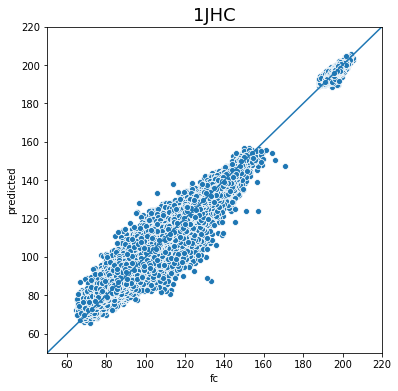

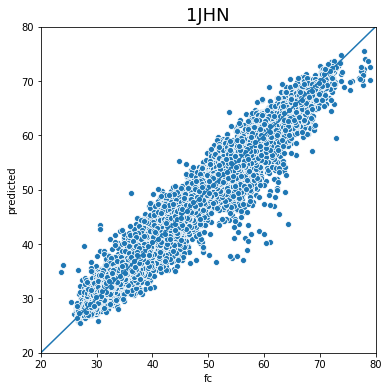

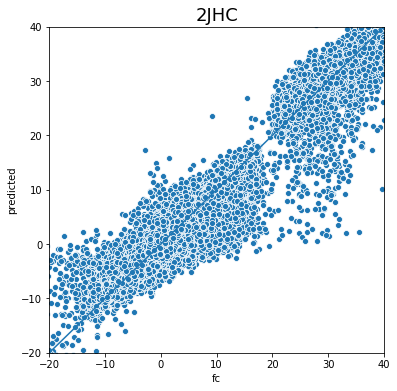

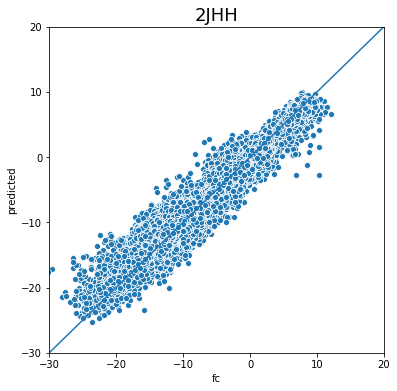

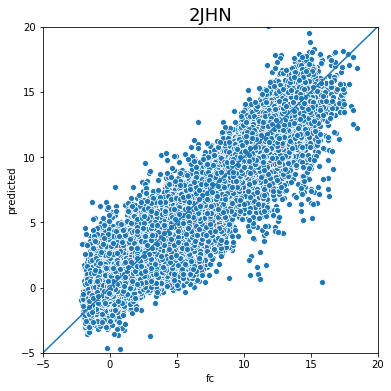

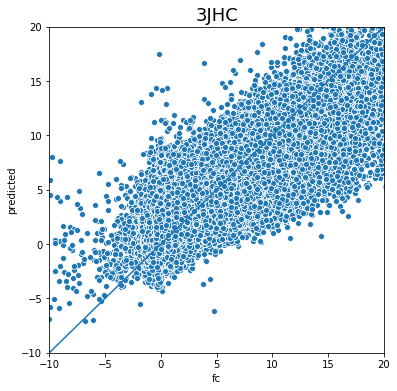

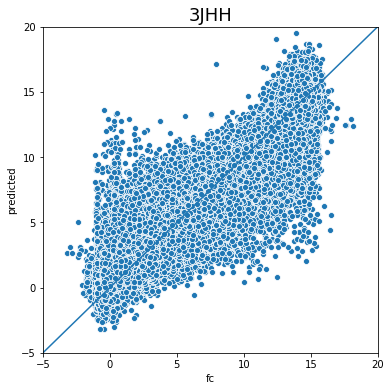

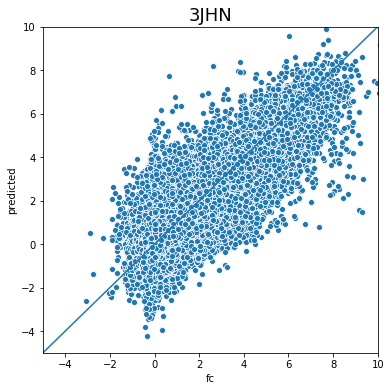

In [27]:
plot_data = pd.DataFrame(y_fc, columns=['fc'])
plot_data.index.name = 'id'
plot_data['yhat'] = result_dict['oof']
plot_data['type'] = lbl.inverse_transform(X['type'])

def plot_oof_preds(ctype, llim, ulim):
        plt.figure(figsize=(6,6))
        sns.scatterplot(x='fc',y='yhat',
                        data=plot_data.loc[plot_data['type']==ctype,
                        ['fc', 'yhat']]);
        plt.xlim((llim, ulim))
        plt.ylim((llim, ulim))
        plt.plot([llim, ulim], [llim, ulim])
        plt.xlabel('fc')
        plt.ylabel('predicted')
        plt.title(f'{ctype}', fontsize=18)
        plt.show()

plot_oof_preds('1JHC', 50, 220)
plot_oof_preds('1JHN', 20, 80)
plot_oof_preds('2JHC', -20, 40)
plot_oof_preds('2JHH', -30, 20)
plot_oof_preds('2JHN', -5, 20)
plot_oof_preds('3JHC', -10, 20)
plot_oof_preds('3JHH', -5, 20)
plot_oof_preds('3JHN', -5, 10)

---> 上図はあくまで、fc を train data で学習してtrain data を予測したに過ぎないことに注意。  
---> 結果としては悪くない
---> では、train data と、test data にfc を追加しよう。  
---> train data は元データを。test data には、予測データを格納する。

---
**add fc data**

In [28]:
X['fc'] = result_dict['oof']
X_test['fc'] = result_dict['prediction']

# Training model
- 上では、test data の 特徴量fc を予測しtest data に追加した。
- 新しいX, X_test を用いて、学習、予測を行う。

**params**

In [31]:
# Configuration
TARGET = 'scalar_coupling_constant'
CAT_FEATS = ['type']
N_ESTIMATORS = 1500
VERBOSE = 500
EARLY_STOPPING_ROUNDS = 200
RANDOM_STATE = 529
METRIC = mean_absolute_error

# lightgbm params
lgb_params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }


In [48]:
n_folds = 3
folds = KFold(n_splits=n_folds, shuffle=True)

# init
result_dict = {}
oof = np.zeros(len(X))
prediction = np.zeros(len(X_test))
scores = []
models = []
feature_importance = pd.DataFrame()
for fold_n, (train_idx, valid_idx) in enumerate(folds.split(X)):
    print('------------------')
    print(f'- fold{fold_n + 1}' )
    print(f'Fold {fold_n + 1} started at {time.ctime()}')
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y[train_idx], y[valid_idx]
    
    # Train the model
    model = lgb.LGBMRegressor(**lgb_params, n_estimators=N_ESTIMATORS, n_jobs=7)
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)],
              verbose=VERBOSE,
              early_stopping_rounds=EARLY_STOPPING_ROUNDS)
    
    # predict
    y_valid_pred = model.predict(X_valid, num_iteration=model.best_iteration_)   # oof: out of folds
    y_test_pred = model.predict(X_test)
    
    oof[valid_idx] = y_valid_pred.reshape(-1,)
    scores.append(METRIC(y_valid, y_valid_pred))
    
    prediction += y_test_pred
    
    # feature_importance
    fold_importance = pd.DataFrame()
    fold_importance['feature'] = X.columns
    fold_importance['importance'] = model.feature_importances_
    fold_importance['fold'] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

# result
prediction /= folds.n_splits
feature_importance["importance"] /= folds.n_splits
result_dict['oof'] = oof
result_dict['prediction'] = prediction
result_dict['scores'] = scores
result_dict['feature_importance'] = feature_importance


print('------------------')
print('====== finish ======')
print('score list:', scores)
X['scalar_coupling_constant'] = y
metric = kaggle_metric(X, oof)
X = X.drop(['scalar_coupling_constant', 'prediction'], axis=1)
print('CV mean score(group log mae): {0:.4f}'.format(metric))

------------------
- fold1
Fold 1 started at Sun Jun 30 07:28:30 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.902343	valid_1's l1: 0.948865
[1000]	training's l1: 0.838101	valid_1's l1: 0.920912
[1500]	training's l1: 0.785162	valid_1's l1: 0.897872
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.785162	valid_1's l1: 0.897872
------------------
- fold2
Fold 2 started at Sun Jun 30 07:38:29 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.903604	valid_1's l1: 0.948999
[1000]	training's l1: 0.838706	valid_1's l1: 0.919832
[1500]	training's l1: 0.787284	valid_1's l1: 0.898558
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.787284	valid_1's l1: 0.898558
------------------
- fold3
Fold 3 started at Sun Jun 30 07:48:07 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.899973	valid_1's l1: 0.94939
[1000]	training's l1: 0

## plot feature importance

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



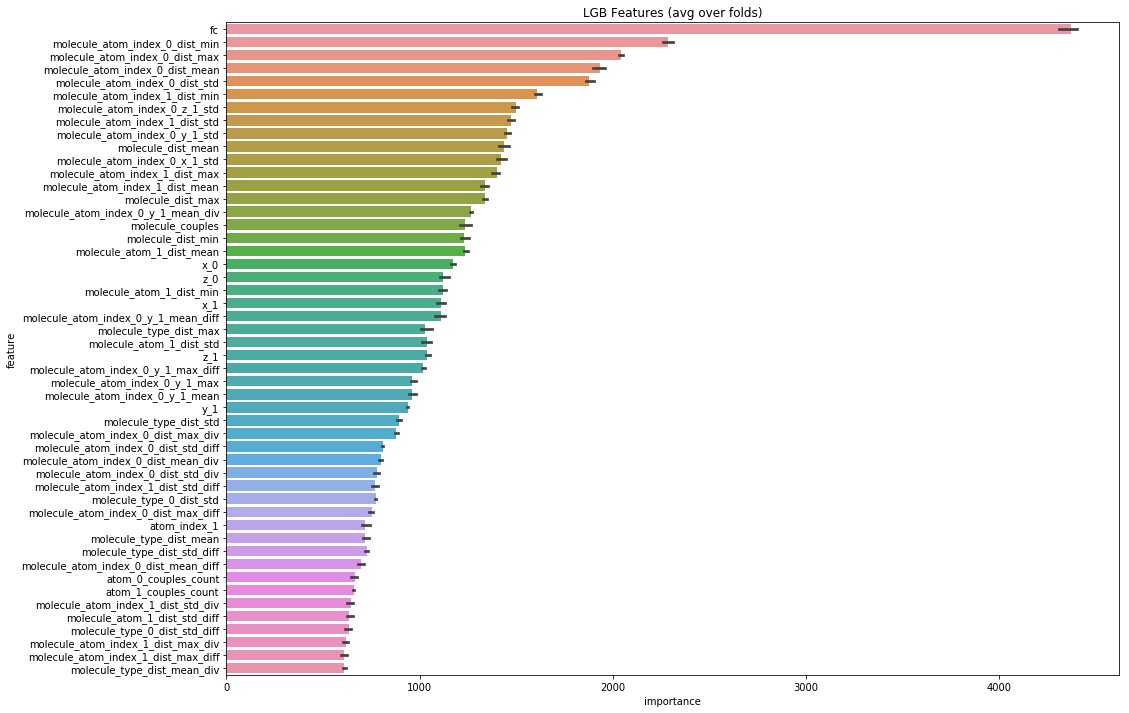

In [49]:
# top 50 features
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

# Save

**submission**

In [50]:
# path_submittion = './output/' + 'nb{}_submission_lgb_{}.csv'.format(nb, metric)
path_submittion = 'nb{}_submission_lgb_{}.csv'.format(nb, metric)
print(f'save pash: {path_submittion}')

save pash: nb20_submission_lgb_-0.28471684197364716.csv


In [ ]:
submittion = pd.read_csv('./input/champs-scalar-coupling/sample_submission.csv')
# submittion = pd.read_csv('./input/champs-scalar-coupling/sample_submission.csv')[::100]
submittion['scalar_coupling_constant'] = prediction
submittion.to_csv(path_submittion, index=False)

---
**result**

In [52]:
path_oof = './output/' + 'nb{}_oof_lgb_{}.csv'.format(nb, metric)
print(f'save pash: {path_oof}')

save pash: ./output/nb20_oof_lgb_-0.28471684197364716.csv


In [53]:
oof = pd.DataFrame(result_dict['oof'])
oof.to_csv(path_oof, index=False)

FileNotFoundError: [Errno 2] No such file or directory: './output/nb20_oof_lgb_-0.28471684197364716.csv'

# analysis

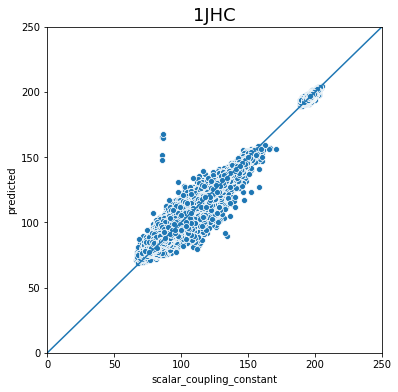

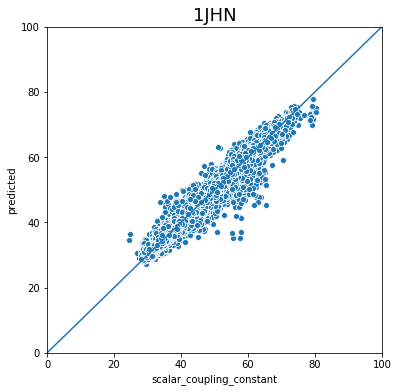

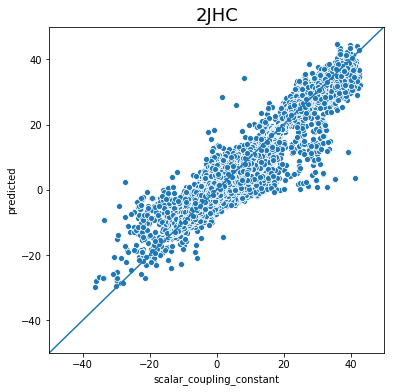

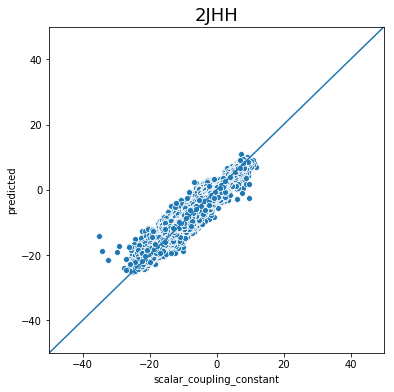

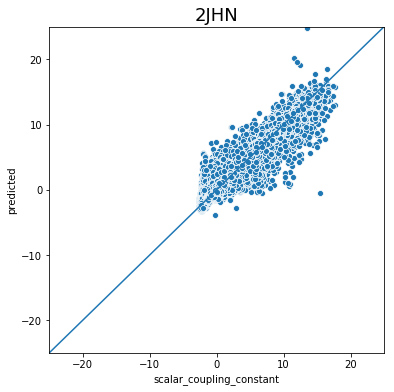

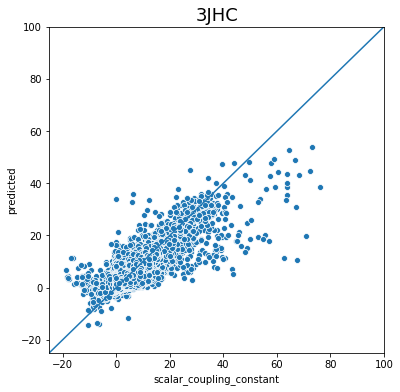

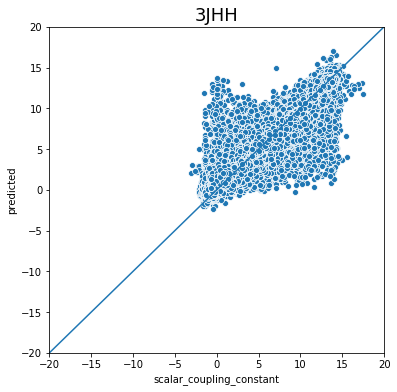

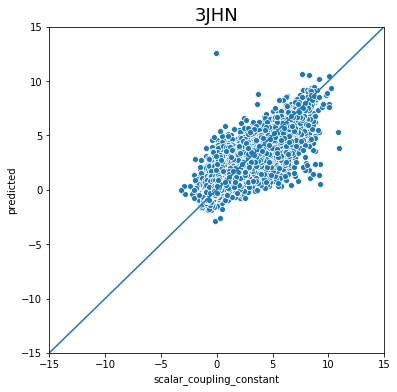

In [54]:
plot_data = pd.DataFrame(y)
plot_data.index.name = 'id'
plot_data['yhat'] = result_dict['oof']
plot_data['type'] = lbl.inverse_transform(X['type'])

def plot_oof_preds(ctype, llim, ulim):
        plt.figure(figsize=(6,6))
        sns.scatterplot(x='scalar_coupling_constant',y='yhat',
                        data=plot_data.loc[plot_data['type']==ctype,
                        ['scalar_coupling_constant', 'yhat']]);
        plt.xlim((llim, ulim))
        plt.ylim((llim, ulim))
        plt.plot([llim, ulim], [llim, ulim])
        plt.xlabel('scalar_coupling_constant')
        plt.ylabel('predicted')
        plt.title(f'{ctype}', fontsize=18)
        plt.show()

plot_oof_preds('1JHC', 0, 250)
plot_oof_preds('1JHN', 0, 100)
plot_oof_preds('2JHC', -50, 50)
plot_oof_preds('2JHH', -50, 50)
plot_oof_preds('2JHN', -25, 25)
plot_oof_preds('3JHC', -25, 100)
plot_oof_preds('3JHH', -20, 20)
plot_oof_preds('3JHN', -15, 15)